In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns

from src.problem_loaders.tsp_loader import TSPLoader
from src.algorithms.ga_tsp import GeneticAltorithmTSP

In [2]:
PROBLEM_INSTANCE_NAME = 'FIVE'

tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance = tsp_loader.load_problem_instance()
ga = GeneticAltorithmTSP(problem_instance)

In [3]:
problem_instance

array([[0., 3., 4., 2., 7.],
       [3., 0., 4., 6., 3.],
       [4., 4., 0., 5., 8.],
       [2., 6., 5., 0., 6.],
       [7., 3., 8., 6., 0.]])

In [4]:
# best solution to find
ga._evaluate_fitness(np.array([0, 2, 1, 4, 3]))

19.0

In [5]:
ga.run()
ga_stats = ga.fitness_df()

Generation: 100%|██████████| 100/100 [00:01<00:00, 88.39it/s]


<AxesSubplot: xlabel='generation', ylabel='fitness'>

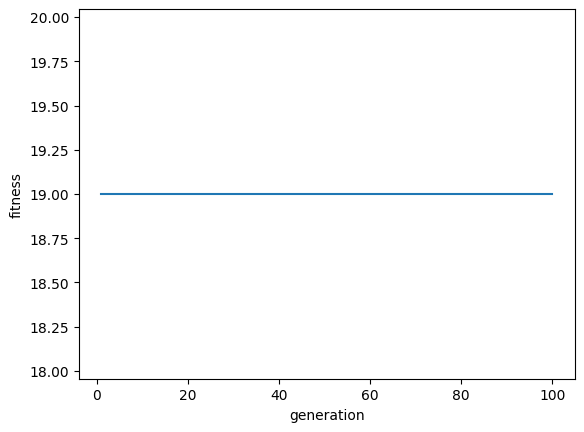

In [6]:
sns.lineplot(data=ga_stats, x='generation', y='fitness')

Generation: 100%|██████████| 300/300 [00:38<00:00,  7.70it/s]


<AxesSubplot: xlabel='generation', ylabel='fitness'>

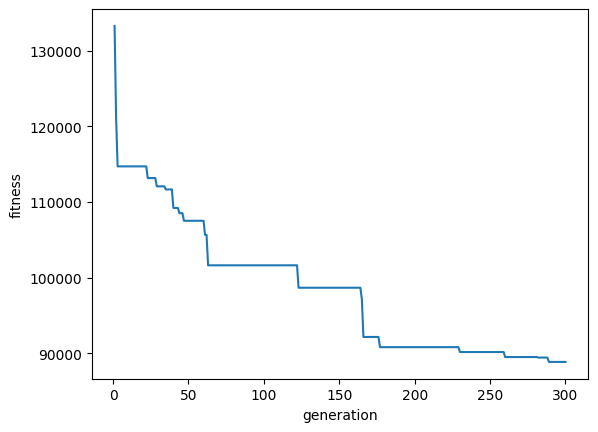

In [7]:
PROBLEM_INSTANCE_NAME = 'ATT48'

tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance = tsp_loader.load_problem_instance()
ga = GeneticAltorithmTSP(problem_instance, population_size=200, max_generations=300)
ga.run()
ga_stats = ga.fitness_df()
sns.lineplot(data=ga_stats, x='generation', y='fitness')